In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from PIL import Image
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
!gdown 1rMyn9gCtsMu0EX_UeigXn6PBwIToRGov

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1rMyn9gCtsMu0EX_UeigXn6PBwIToRGov 



In [4]:
!wget "http://seppe.net/aa/assignment2/images.zip"

--2023-05-24 06:30:16--  http://seppe.net/aa/assignment2/images.zip
Resolving seppe.net (seppe.net)... 37.139.1.16
Connecting to seppe.net (seppe.net)|37.139.1.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21223409265 (20G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  19.77G   170MB/s    in 2m 23s  

2023-05-24 06:32:39 (141 MB/s) - ‘images.zip’ saved [21223409265/21223409265]



In [5]:
!7z x images.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 21223409265 bytes (20 GiB)

Extracting archive: images.zip
  3% 4096 Open              --
Path = images.zip
Type = zip
Physical Size = 21223409265
64-bit = +

  0%      0% 168 - images/1001872.jpg                               0% 290 - images/1003943.jpg                               0% 421 - images/1005580.jpg                               0% 574 - images/1007423.jpg                               0% 705 - images/1009442.jpg

In [6]:
import os
import tensorflow as tf
from PIL import Image
## checking whether images are in an ok format
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Attempt to load and verify the image file
        return True
    except (IOError, SyntaxError):
        return False

def check_and_clean_directory(directory):
    invalid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                invalid_images.append(file_path)
    
    # Print invalid image names
    for file_path in invalid_images:
        print(f'Invalid image: {file_path}')
    
    # Delete invalid images
    for file_path in invalid_images:
        os.remove(file_path)
        print(f'Deleted invalid image: {file_path}')

# Set the path to your directory containing the images
directory_path = '/content/images'

# Check and clean the directory
check_and_clean_directory(directory_path)


Invalid image: /content/images/4215425.jpg
Deleted invalid image: /content/images/4215425.jpg


In [7]:
import pandas as pd

# Read the CSV file
csv_path = '/content/drive/MyDrive/info.csv'
df = pd.read_csv(csv_path)

# Filter out images with no categories
df_filtered = df.dropna(subset=['price_category'])
image_ids = df_filtered['image_id']
categories = df_filtered['price_category']

### Pre-processing data

In [8]:
# Create train and test dir
import os

# Specify the path for train and test folders
train_dir = '/content/train'
test_dir= '/content/test'

# Create train and test folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [9]:
import shutil

# Create train and test directories for each category
for category in set(categories):
    category_str = str(category)  # Convert category to string
    train_category_dir = os.path.join(train_dir, category_str)
    os.makedirs(train_category_dir, exist_ok=True)
    test_category_dir = os.path.join(test_dir, category_str)
    os.makedirs(test_category_dir, exist_ok=True)

from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_image_ids, test_image_ids, train_categories, test_categories = train_test_split(
    image_ids, categories, test_size=0.3, random_state=42)

# Function to copy images to the destination directory
def copy_image(image_id, category, source_dir, destination_dir):
    image_file = f'{image_id}.jpg'
    source_path = os.path.join(source_dir, image_file)
    destination_path = os.path.join(destination_dir, image_file)
    shutil.copyfile(source_path, destination_path)

# Copy images to train directory
for image_id, category in zip(train_image_ids, train_categories):
    try:
        copy_image(image_id, category, directory_path, os.path.join(train_dir, category))
    except Exception as e:
        print(f"Error occurred while copying image {image_id} to the train directory: {str(e)}")

# Copy images to test directory
for image_id, category in zip(test_image_ids, test_categories):
    try:
        copy_image(image_id, category, directory_path, os.path.join(test_dir, category))
    except Exception as e:
        print(f"Error occurred while copying image {image_id} to the test directory: {str(e)}")


Error occurred while copying image 4215425 to the test directory: [Errno 2] No such file or directory: '/content/images/4215425.jpg'


In [ ]:
def count_images_in_folder(folder_path, extension):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(extension):
                count += 1
    return count


# Count images in the train directory
train_image_count = count_images_in_folder(test_dir, '.jpg')
print(f"Number of images in train directory: {train_image_count}")


Number of images in train directory: 34698


### Transfer learning

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the paths to your train and test directories
train_dir = '/content/train'
test_dir = '/content/test'

# Set the image dimensions
image_size = (224, 224)  # Adjust according to your model's input size

# Set up the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

# Set up the ImageDataGenerator for test data (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

# Load the test data without augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 80962 images belonging to 4 classes.
Found 34698 images belonging to 4 classes.


In [12]:
for images, labels in train_generator:
    # images is a batch of image tensors
    # labels is a batch of corresponding label tensors

    # Print the shape of the image tensors
    print('Image shape:', images.shape)
    
    # Print the shape of the label tensors
    print('Label shape:', labels.shape)

    # You can also access individual images and labels in the batch
    for i in range(images.shape[0]):
        image = images[i]
        label = labels[i]

        # Process the image or perform any desired operations
        # ...

        # Print the image tensor shape
        print('Individual image shape:', image.shape)
        
        # Print the label tensor
        print('Label:', label)

    # Break the loop to avoid an infinite iteration
    break


Image shape: (32, 224, 224, 3)
Label shape: (32, 4)
Individual image shape: (224, 224, 3)
Label: [1. 0. 0. 0.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [1. 0. 0. 0.]
Individual image shape: (224, 224, 3)
Label: [1. 0. 0. 0.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [1. 0. 0. 0.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 1. 0.]
Individual image shape: (224, 224, 3)
Label: [1. 0. 0. 0.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 1. 0.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 0. 0. 1.]
Individual image shape: (224, 224, 3)
Label: [0. 1. 0. 0.]
Indi

In [13]:
# Load the EfficientNetB0 pre-trained model without the top (fully connected) layers
img_width = 224 
img_height = 224
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 4 output units (one for each class)
predictions = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


16705208/16705208 [==============================] - 1s 0us/step


In [14]:
import shutil
# Delete the non-empty directory
#shutil.rmtree('/content/images')

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
import matplotlib.pyplot as plt

In [16]:
# Compile the model
model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define history callback
history = History()


In [17]:
# Train the model with early stopping and history callback
hist = model.fit(
    training_data=train_generator,
    steps_per_epoch=500,
    epochs=15,
    validation_data=test_generator,
    validation_steps=500,
    callbacks=[early_stopping, history]
)

Epoch 1/15
500/500 [==============================] - 1124s 2s/step - loss: 1.3489 - accuracy: 0.3617 - val_loss: 0.9243 - val_accuracy: 0.9118
Epoch 2/15
500/500 [==============================] - 1062s 2s/step - loss: 1.3340 - accuracy: 0.3749 - val_loss: 0.7269 - val_accuracy: 0.9118
Epoch 3/15
500/500 [==============================] - 1108s 2s/step - loss: 1.3216 - accuracy: 0.3823 - val_loss: 1.0100 - val_accuracy: 0.9118
Epoch 4/15
500/500 [==============================] - 1093s 2s/step - loss: 1.3187 - accuracy: 0.3798 - val_loss: 1.0856 - val_accuracy: 0.9118
Epoch 5/15
500/500 [==============================] - 1105s 2s/step - loss: 1.3416 - accuracy: 0.3734 - val_loss: 1.0807 - val_accuracy: 0.9118


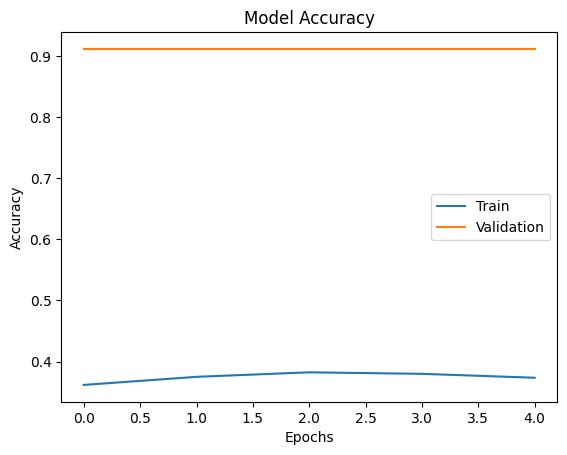

In [18]:
# Plot the training and validation accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

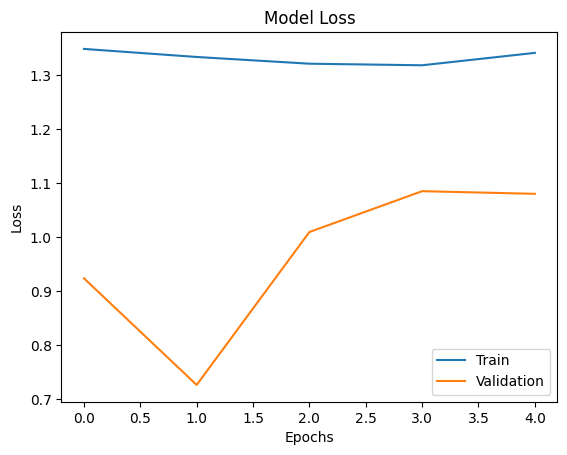

In [19]:
# Plot the training and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Save the final model
model.save('final_model.h5')

1/1 [==============================] - 0s 49ms/step


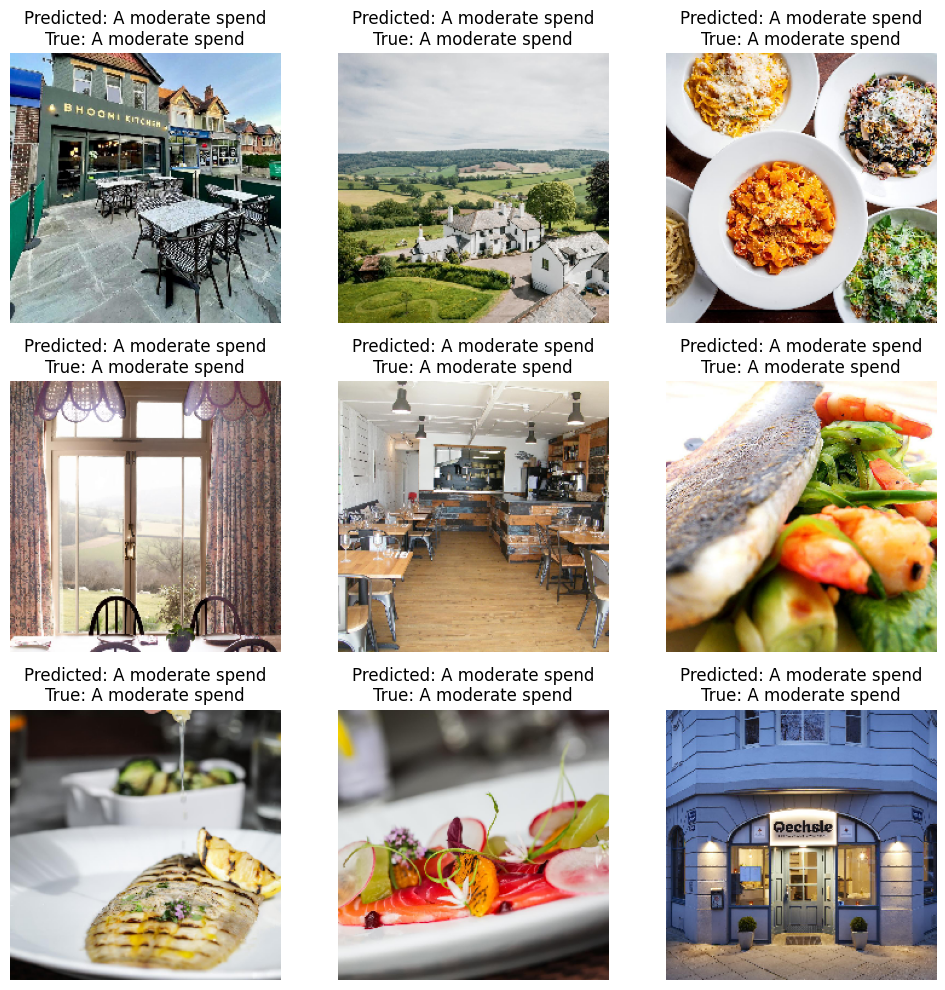

In [26]:
import matplotlib.pyplot as plt
# Load 9 test images and their labels
test_images, test_labels = next(iter(test_generator))
test_images = test_images[:9]
test_labels = test_labels[:9]

# Make predictions on the test images
predictions = model.predict(test_images)

# Get the class labels for the predictions
class_labels = train_generator.class_indices

# Reverse the class labels dictionary
class_labels = {v: k for k, v in class_labels.items()}

# Plot the test images and their predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Display the test image
    ax.imshow(test_images[i])
    ax.axis('off')

    # Get the predicted class label
    predicted_class = class_labels[np.argmax(predictions[i])]
    true_class = class_labels[np.argmax(test_labels[i])]

    # Set the title of the plot with the predicted and true labels
    ax.set_title(f'Predicted: {predicted_class}\nTrue: {true_class}')

plt.tight_layout()
plt.show()



In [35]:
import os
from PIL import Image
import imagehash

image_dir = '/content/images'

# Get the list of image files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Create a dictionary to store the image hashes
image_hashes = {}

# Iterate over the image files and calculate their hashes
for file in image_files:
    file_path = os.path.join(image_dir, file)
    try:
        with Image.open(file_path) as img:
            img_hash = imagehash.average_hash(img)
            if img_hash in image_hashes:
                # Duplicate image found
                print(f"Duplicate image: {file} and {image_hashes[img_hash]}")
            else:
                image_hashes[img_hash] = file
    except Exception as e:
        print(f"Error occurred while processing image: {file} - {str(e)}")


Duplicate image: 1377154.jpg and 358994.jpg
Duplicate image: 3934033.jpg and 358994.jpg
Duplicate image: 1123907.jpg and 292112.jpg
Duplicate image: 1352492.jpg and 358994.jpg
Duplicate image: 495553.jpg and 358994.jpg
Duplicate image: 282874.jpg and 253141.jpg
Duplicate image: 5003913.jpg and 4649139.jpg
Duplicate image: 5440176.jpg and 1036614.jpg
Duplicate image: 1269936.jpg and 292112.jpg
Duplicate image: 1403448.jpg and 358994.jpg
Duplicate image: 4047270.jpg and 1047249.jpg
Duplicate image: 5438793.jpg and 358994.jpg
Duplicate image: 4072108.jpg and 4582600.jpg
Duplicate image: 669332.jpg and 714433.jpg
Duplicate image: 5463773.jpg and 292112.jpg
Duplicate image: 2256617.jpg and 2159855.jpg
Duplicate image: 371878.jpg and 358994.jpg
Duplicate image: 5484549.jpg and 4089832.jpg
Duplicate image: 2134594.jpg and 445435.jpg
Duplicate image: 2005330.jpg and 2060510.jpg
Duplicate image: 5287628.jpg and 358994.jpg
Duplicate image: 2060585.jpg and 2060510.jpg
Duplicate image: 5344584.jpg

KeyboardInterrupt: ignored

### Checking a few images

In [2]:
path = "D:/Advanced Analytics - Lia/images/images"

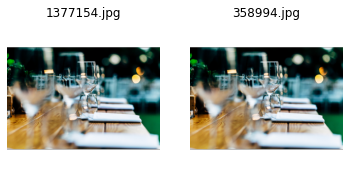

In [5]:
# List of image paths
image_paths = [
    os.path.join(path, "1377154.jpg"),
    os.path.join(path,"358994.jpg")
]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(image_paths))

# Iterate over the image paths and display images with legends
for ax, image_path in zip(axes, image_paths):
    # Read the image and display it on the subplot
    ax.imshow(plt.imread(image_path))
    ax.axis('off')

    # Set the legend for the subplot with the filename
    ax.set_title(os.path.basename(image_path))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the figure
plt.show()

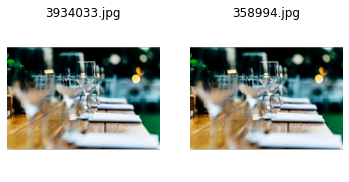

In [6]:
# List of image paths
image_paths = [
    os.path.join(path, "3934033.jpg"),
    os.path.join(path,"358994.jpg")
]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(image_paths))

# Iterate over the image paths and display images with legends
for ax, image_path in zip(axes, image_paths):
    # Read the image and display it on the subplot
    ax.imshow(plt.imread(image_path))
    ax.axis('off')

    # Set the legend for the subplot with the filename
    ax.set_title(os.path.basename(image_path))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the figure
plt.show()

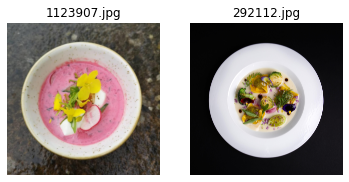

In [7]:
# List of image paths
image_paths = [
    os.path.join(path, "1123907.jpg"),
    os.path.join(path,"292112.jpg")
]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(image_paths))

# Iterate over the image paths and display images with legends
for ax, image_path in zip(axes, image_paths):
    # Read the image and display it on the subplot
    ax.imshow(plt.imread(image_path))
    ax.axis('off')

    # Set the legend for the subplot with the filename
    ax.set_title(os.path.basename(image_path))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the figure
plt.show()

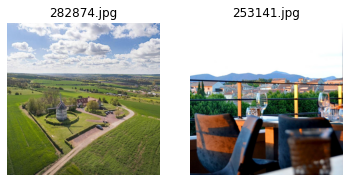

In [9]:
# List of image paths
image_paths = [
    os.path.join(path, "282874.jpg"),
    os.path.join(path,"253141.jpg")
]

# Create a figure with subplots
fig, axes = plt.subplots(1, len(image_paths))

# Iterate over the image paths and display images with legends
for ax, image_path in zip(axes, image_paths):
    # Read the image and display it on the subplot
    ax.imshow(plt.imread(image_path))
    ax.axis('off')

    # Set the legend for the subplot with the filename
    ax.set_title(os.path.basename(image_path))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the figure
plt.show()

In [20]:
id1 = df.loc[df['image_id'] == 1377154, ['identifier', 'price_category']].values
print(id1)
id2 = df.loc[df['image_id'] == 358994, ['identifier', 'price_category']].values
print(id2)

[[224130 'A moderate spend']]
[[274087 'Special occasion']]


In [21]:
id3 = df.loc[df['image_id'] == 3934033, ['identifier', 'price_category']].values
print(id3)
id4 = df.loc[df['image_id'] == 358994, ['identifier', 'price_category']].values
print(id4)

[[151217 'A moderate spend']]
[[274087 'Special occasion']]


In [22]:
id5 = df.loc[df['image_id'] == 1123907, ['identifier', 'price_category']].values
print(id5)
id6 = df.loc[df['image_id'] == 292112, ['identifier', 'price_category']].values
print(id6)

[[318389 'Special occasion']]
[[69260 'Spare no expense']]


In [23]:
id7 = df.loc[df['image_id'] == 282874, ['identifier', 'price_category']].values
print(id7)
id8 = df.loc[df['image_id'] == 253141, ['identifier', 'price_category']].values
print(id8)

[[391387 'A moderate spend']]
[[1195745 'A moderate spend']]


### Trying some different parameters

In [61]:
import numpy as np

# Calculate class frequencies
class_labels = np.unique(train_generator.classes)
class_counts = np.bincount(train_generator.classes)

# Calculate class weights
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_labels) * class_counts)

# Create a dictionary of class weights
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 0.5935456438227618, 1: 3.3983378106111486, 2: 1.3323130595050026, 3: 0.7871699140512581}


In [63]:
# Train the model with early stopping and history callback
hist2 = model.fit(
    train_generator,
    steps_per_epoch=1000,
    epochs=15,
    validation_data=test_generator,
    validation_steps=1000,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, history]
)


Epoch 1/15
1000/1000 [==============================] - 1502s 2s/step - loss: 1.5161 - accuracy: 0.2460 - val_loss: 2.1011 - val_accuracy: 0.0000e+00
Epoch 2/15
1000/1000 [==============================] - 1499s 1s/step - loss: 1.5346 - accuracy: 0.2428 - val_loss: 1.3958 - val_accuracy: 0.0000e+00
Epoch 3/15
 103/1000 [==>...........................] - ETA: 19:14 - loss: 1.5233 - accuracy: 0.2285

KeyboardInterrupt: ignored

In [ ]:
# Train the model with early stopping and history callback
hist2 = model.fit(
    train_generator,
    steps_per_epoch=1000,
    epochs=15,
    validation_data=test_generator,
    validation_steps=1000,
    callbacks=[early_stopping, history]
)

Epoch 1/15
1000/1000 [==============================] - 1453s 1s/step - loss: 1.3019 - accuracy: 0.3808 - val_loss: 1.0708 - val_accuracy: 0.1311
Epoch 2/15
1000/1000 [==============================] - 1466s 1s/step - loss: 1.3247 - accuracy: 0.3770 - val_loss: 0.6190 - val_accuracy: 1.0000
Epoch 3/15
1000/1000 [==============================] - 1455s 1s/step - loss: 1.3218 - accuracy: 0.3730 - val_loss: 0.5683 - val_accuracy: 1.0000
Epoch 4/15
 908/1000 [==========================>...] - ETA: 1:55 - loss: 1.3250 - accuracy: 0.3804